# NN-VMC with self-attention wave function ansatz

In [10]:
import tqdm
import equinox as eqx
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import optax
import netket as nk
from jaxtyping import Array, PyTree, Float, Complex, PRNGKeyArray

import matplotlib.pyplot as plt

from models.slaternet import SlaterNet
from models.psi_solid import PsiSolid

from systems.continuous import moire
from utils.sampler import make_mh_sampler, metropolis_hastings


key = jax.random.key(42)

c:\workspace\physics\attention-wavefn\atten-wfn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


\begin{equation}
    H=\sum_i\left(-\frac{1}{2}\nabla_i^2 + V(\mathbf r_i)\right) + \sum_{i < j}\frac{1}{|\mathbf r_i-\mathbf r_j|}
\end{equation}
- Moire potential:
\begin{equation}
    V(\mathbf r) = -2V_0\sum_{j=0}^2 \cos(\mathbf g_j\cdot\mathbf r + \varphi)
\end{equation}
Where $\mathbf g_j=\frac{4\pi}{\sqrt{3}a_M}\left(\cos\frac{2\pi j}{3},\sin\frac{2\pi j}{3}\right)$.

- Units
  - mass: Electron mass, $m_e$
  - Length: Effective Bohr radius, $a_0^* = \epsilon\dfrac{m_e}{m^*} a_0$
  - Energy: Effective Hartree, $\mathrm{Ha}^* = \dfrac{1}{\epsilon^2}\dfrac{m^*}{m_e}\mathrm{Ha}$

## System paramerters

In [2]:
# system parameters
a_0 = 5.291_772_105_44e-11 # m
m_e = 9.109_383_7139e-31 # kg
Ha = 4.359_744_722_2060e-18 # J = kg m^2/s^2
meV = 1.60218e-22 # J = kg m^2/s^2
nm = 1e-9 # m


epsilon = 5
# epsilon = 10
m_eff = 0.35 * m_e
a_B_eff = epsilon * (m_e / m_eff) * a_0
Ha_eff = (1 / (epsilon ** 2)) * (m_eff / m_e) * Ha


V0 = 15 * meV / Ha_eff
a_M = 8.031 * nm / a_B_eff
varphi = jnp.pi / 4
(V0, a_M, varphi)

(0.0393743564807352, 10.623473362015782, 0.7853981633974483)

In [3]:
primitive_latt_vects = a_M * jnp.array([
    [jnp.cos(-jnp.pi / 2), jnp.sin(-jnp.pi / 2)],
    [jnp.cos(jnp.pi / 6), jnp.sin(jnp.pi / 6)]
]) # [a_0, a_1]

primitive_recip_latt_vects = ((4 * jnp.pi) / (jnp.sqrt(3) * a_M)) * jnp.array([
    [jnp.cos(-jnp.pi / 3), jnp.sin(-jnp.pi / 3)],
    [jnp.cos(0), jnp.sin(0)]
]) # [b_0, b_1]
# a_i \cdot b_j = 2 \pi \delta_{ij}

(min1, max1) = (-2, 2)
(min2, max2) = (-2, 2)

(minu, maxu) = (min1 + 1/2, max1 + 1/2)
(minv, maxv) = (min2 + 1/2, max2 + 1/2)

N_elec = 16

# parametrization:
u, v = 0.1234, 1.1245
R = u * primitive_latt_vects[0] + v * primitive_latt_vects[1]
def indicator(x):
    u = jnp.dot(primitive_recip_latt_vects[0], x) / (2 * jnp.pi)
    v = jnp.dot(primitive_recip_latt_vects[1], x) / (2 * jnp.pi)
    return (minu <= u) & (u <= maxu) & (minv <= v) & (v <= maxv)

@jax.jit
def N_dim_indicator(R):
    return jnp.all(jax.vmap(indicator)(R))

# super cell: L_x := (max1 - min1) by L_y := (max2 - min2) cell, L_x L_y atoms)
from math import ceil
Nx = ceil(max1 - min1)
Ny = ceil(max2 - min2)
G = jnp.stack([
    primitive_recip_latt_vects[0] / Nx,
    primitive_recip_latt_vects[1] / Ny,
])

## Initializing Models

In [4]:
subkey, key = jax.random.split(key)

slater_wavefn = SlaterNet(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    mlp_depth=8,
    key=subkey,
)

In [5]:
subkey, key = jax.random.split(key)

psi_solid_wavefn = PsiSolid(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    intermediate_dim=64,
    attention_dim=16,
    num_heads=6,
    num_blocks=3, 
    num_mlp_layers=2,
    num_det=4,
    key=subkey,
)

## Samplers

In [6]:
subkey, key = jax.random.split(key)
R0 = jax.random.normal(subkey, (N_elec, 2))
psi_solid_wavefn(R0)

Array(3.82886634e-38+2.86023767e-38j, dtype=complex128)

0.4597
0.47070312


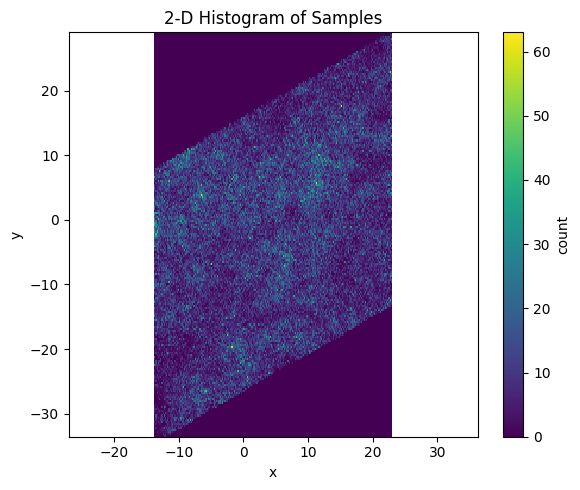

In [7]:
subkey, key = jax.random.split(key)

NDind = lambda x: jnp.all(jax.vmap(indicator)(x))
rho = lambda x: psi_solid_wavefn(x).conj() * psi_solid_wavefn(x)

# burnin
samples, acceptance_rate = metropolis_hastings(
    subkey,
    R0,
    10000,
    0.5,
    NDind, rho
)
R0 = samples[-1]

print(acceptance_rate)

subkey, key = jax.random.split(key)

samples, acceptance_rate = metropolis_hastings(
    subkey,
    R0,
    16384,
    0.5,
    NDind, rho
)
R0 = samples[-1]

print(acceptance_rate)
points = samples.reshape(-1, 2)

plt.figure(figsize=(6, 5))
plt.hist2d(
    points[:, 0],   # x 축
    points[:, 1],   # y 축
    bins=200,             # 격자 수(원하는 해상도로 조정)
    density=False         # 빈도수 그대로 볼 때 False, 확률밀도로 보려면 True
)
plt.colorbar(label='count')  # 각 칸의 샘플 개수 표시
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Histogram of Samples')
plt.tight_layout()
plt.axis('equal')
plt.show()

## Train loop

In [ ]:
def train(
    wave_fn: eqx.Module,
    optim: optax.GradientTransformation,
    R0: Float[Array, "n_par spc_dim"],
    batch_size: int,
    steps: int,
    key: PRNGKeyArray
):
    opt_state = optim.init(eqx.filter(wave_fn, eqx.is_array))

    energies = np.zeros(steps)
    gradnorms = np.zeros(steps)
    acceptance_rates = np.zeros(steps)
    
    @eqx.filter_jit
    def make_step(
        wave_fn: eqx.Module,
        opt_state: PyTree,
        R0: Float[Array, "n_par spc_dim"],
        key: PRNGKeyArray
    ):
        # MCMC sampling
        samples, acceptance_rate = metropolis_hastings(
            key,
            R0,
            batch_size,
            0.5,
            N_dim_indicator, 
            lambda x: jnp.abs(wave_fn(x).conj() * wave_fn(x))
        )
        R0 = samples[-1]
        
        # local energy
        E_locs = jax.vmap(moire.local_energy,
                          in_axes=(None, 0, None, None, None))(
            wave_fn, samples, V0, a_M, varphi
        ) # (batch,)
        E_locs = jnp.real(E_locs)
                          
        # grad_log_psi_square
        def log_psi_square(wfn, x):
            return jnp.log(jnp.abs(wfn(x).conj() * wfn(x)))

        def grad_log_psi_square(wfn, x):
            return eqx.filter_grad(log_psi_square)(wfn, x)
        
        grad_log_psi_squares = jax.vmap(grad_log_psi_square, in_axes=(None, 0))(wave_fn, samples)

        # match mean
        E_mean = jnp.mean(E_locs)
        # print(E_locs)
        # print(E_mean) # E_loc이 Real이 아님. 왜??? < 개망함 내일하자
         
        grad_log_psi_squares_mean = jax.tree_util.tree_map(lambda g: jnp.mean(g, axis=0), grad_log_psi_squares)
        
        # covariance
        centered_E = E_locs - E_mean
        def vmc_cov(g, g_mean):
            centered_g = g - g_mean
            return jnp.einsum('b,b...->...', centered_E, centered_g) / batch_size
        grads = jax.tree_util.tree_map(vmc_cov, grad_log_psi_squares, grad_log_psi_squares_mean)
        
        updates, opt_state = optim.update(
            eqx.filter(grads, eqx.is_array), opt_state, eqx.filter(wave_fn, eqx.is_array)
        )
        wave_fn = eqx.apply_updates(wave_fn, updates)
        
        grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)))
        
        return wave_fn, opt_state, R0, E_mean, grad_norm, acceptance_rate
    
    pbar = tqdm.trange(steps, desc="training", unit="step")
    for step in pbar:
        key, subkey = jax.random.split(key)
        wave_fn, opt_state, R0, energy, grad_norm, acceptance_rate = make_step(wave_fn, opt_state, R0, subkey)
        energies[step] = float(energy)
        gradnorms[step] = float(grad_norm)
        acceptance_rates[step] = float(acceptance_rate)
        pbar.set_postfix(energy=float(energy), gradnorm=float(grad_norm), mh_acc=float(acceptance_rate))
    
    return wave_fn, energies, gradnorms, acceptance_rates

In [ ]:
n_batches = 1024
n_steps = 1000
start_learning_rate = 1e-3
optim = optax.adam(start_learning_rate)

key, subkey = jax.random.split(key, 2)
wave_fn, energies, gradnorms, acceptance_rates = train(psi_solid_wavefn, optim, R0, n_batches, n_steps, subkey)

training:   0%|          | 0/1000 [00:00<?, ?step/s]

Traced<ShapedArray(float64[1024])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>


training:   3%|▎         | 33/1000 [24:10<11:54:47, 44.35s/step, energy=7.78, gradnorm=9.93, mh_acc=0.396]